In [1]:
import gym
import snake_gym
import PIL.Image

In [2]:
import time
from collections import deque, namedtuple

import numpy as np
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [3]:
env = gym.make('mysnake-v0')

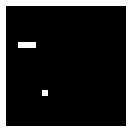

In [4]:
# Visualize the environment of the snake
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [13]:
tf.random.set_seed(utils.SEED)

In [14]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [15]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (11,)
Number of actions: 3


In [16]:
# Reset the environment and get the initial state.
initial_state = env.reset()

In [17]:
# ["STRAIGHT", "LEFT", "RIGHT"] = [0, 1, 2]

# Select an action
action = 2

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

utils.display_table(initial_state, action, next_state, reward, done)

Initial State:,[0 0 0 0 1 0 0 0 1 0 1]
Action:,RIGHT
Next State:,[0 0 0 0 0 0 1 0 1 0 1]
Reward Received:,0.000
Episode Terminated:,False


In [18]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)    

In [19]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [20]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """


    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Calculate the loss
    loss = MSE(y_targets, q_values)

    return loss

In [21]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [22]:
def train(num_episodes=2000, max_num_timesteps=1000, num_train = ""):

    start = time.time()

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
    epsilon = 1.0     # initial ε value for ε-greedy policy

    # Create a memory buffer D with capacity N
    memory_buffer = deque(maxlen=MEMORY_SIZE)

    # Set the target network weights equal to the Q-Network weights
    target_q_network.set_weights(q_network.get_weights())

    for i in range(num_episodes):
        
        # Reset the environment to the initial state and get the initial state
        state = env.reset()


        total_points = 0
        
        for t in range(max_num_timesteps):
            
            # From the current state S choose an action A using an ε-greedy policy
            state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
            q_values = q_network(state_qn)
            
            action = utils.get_action(q_values, epsilon)
            
            # Take action A and receive reward R and the next state S'
            next_state, reward, done, _ = env.step(action)
            
            # Store experience tuple (S,A,R,S') in the memory buffer.
            # We store the done variable as well for convenience.
            memory_buffer.append(experience(state, action, reward, next_state, done))
            
            # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
            update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
            
            if update:
                # Sample random mini-batch of experience tuples (S,A,R,S') from D
                experiences = utils.get_experiences(memory_buffer)
                
                # Set the y targets, perform a gradient descent step,
                # and update the network weights.
                agent_learn(experiences, GAMMA)
            
            state = next_state.copy()
            total_points += reward
            
            if done:
                break
                
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])
        
        # Update the ε value
        epsilon = utils.get_new_eps(epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 200 points in the last 100 episodes.
        if av_latest_points >= 400.0:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            # q_network.save(f'models/mysnake_model_{num_train}.h5')
            break
            
    tot_time = time.time() - start
    q_network.save(f'models/mysnake_model_{num_train}.h5')

    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)") 

    utils.plot_history(total_point_history) 

## First training

In [21]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()


    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('models/mysnake_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -7.10
Episode 200 | Total point average of the last 100 episodes: -1.90
Episode 300 | Total point average of the last 100 episodes: 18.70
Episode 400 | Total point average of the last 100 episodes: 48.90
Episode 500 | Total point average of the last 100 episodes: 82.40
Episode 600 | Total point average of the last 100 episodes: 118.00
Episode 700 | Total point average of the last 100 episodes: 162.20
Episode 785 | Total point average of the last 100 episodes: 201.00

Environment solved in 785 episodes!

Total Runtime: 376.85 s (6.28 min)


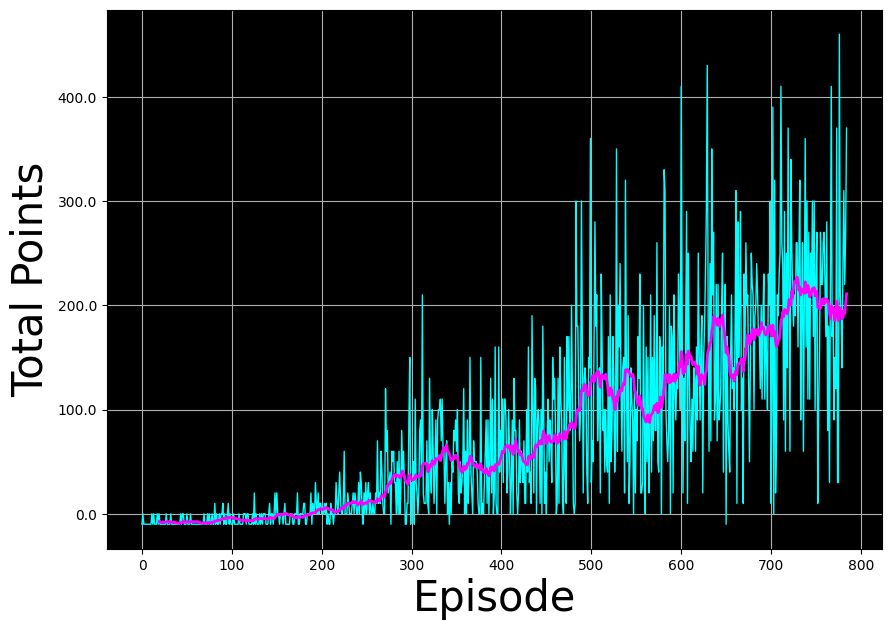

In [23]:
utils.plot_history(total_point_history)

In [24]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [26]:
filename = "./videos/snake.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

In [28]:
filename = "./videos/snake1.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

In [18]:
from keras.models import load_model
model1 = load_model("models/mysnake_model.h5")

In [33]:
q_network.set_weights(model1.get_weights())

In [20]:
filename = "./videos/snake2.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Second training

In [38]:
start = time.time()

num_episodes = 3000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()


    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 400 points in the last 100 episodes.
    if av_latest_points >= 400.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('./models/mysnake_model_2.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -2.90
Episode 200 | Total point average of the last 100 episodes: 6.700
Episode 300 | Total point average of the last 100 episodes: 19.10
Episode 400 | Total point average of the last 100 episodes: 47.20
Episode 500 | Total point average of the last 100 episodes: 73.30
Episode 600 | Total point average of the last 100 episodes: 115.40
Episode 700 | Total point average of the last 100 episodes: 174.50
Episode 800 | Total point average of the last 100 episodes: 203.10
Episode 900 | Total point average of the last 100 episodes: 215.50
Episode 1000 | Total point average of the last 100 episodes: 213.10
Episode 1100 | Total point average of the last 100 episodes: 218.80
Episode 1200 | Total point average of the last 100 episodes: 219.90
Episode 1300 | Total point average of the last 100 episodes: 205.80
Episode 1400 | Total point average of the last 100 episodes: 213.30
Episode 1500 | Total point average of the last 100 episodes: 1

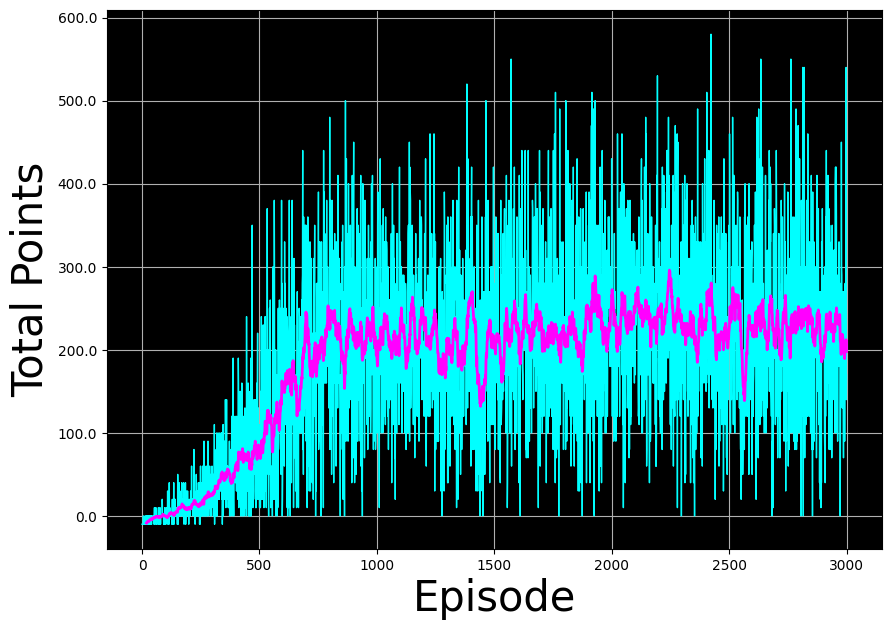

In [39]:
utils.plot_history(total_point_history)

In [42]:
filename = "./videos/snake_T2_1.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [51]:
filename = "./videos/snake_T2_2.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [55]:
filename = "./videos/snake_T2_3.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Third training

In [16]:
start = time.time()
# probar con episodios=1, ... y ver como se comporta
num_episodes = 5000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()


    total_points = 0
    # ver timesteps vs scores para entender el efecto del timestep
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 400 points in the last 100 episodes.
    if av_latest_points >= 600.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('./models/mysnake_model_3.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -9.20
Episode 200 | Total point average of the last 100 episodes: -8.00
Episode 300 | Total point average of the last 100 episodes: 5.800
Episode 400 | Total point average of the last 100 episodes: 43.10
Episode 500 | Total point average of the last 100 episodes: 85.50
Episode 600 | Total point average of the last 100 episodes: 117.00
Episode 700 | Total point average of the last 100 episodes: 173.20
Episode 800 | Total point average of the last 100 episodes: 200.90
Episode 900 | Total point average of the last 100 episodes: 192.00
Episode 1000 | Total point average of the last 100 episodes: 216.90
Episode 1100 | Total point average of the last 100 episodes: 229.00
Episode 1200 | Total point average of the last 100 episodes: 233.30
Episode 1300 | Total point average of the last 100 episodes: 215.70
Episode 1400 | Total point average of the last 100 episodes: 221.90
Episode 1500 | Total point average of the last 100 episodes: 2

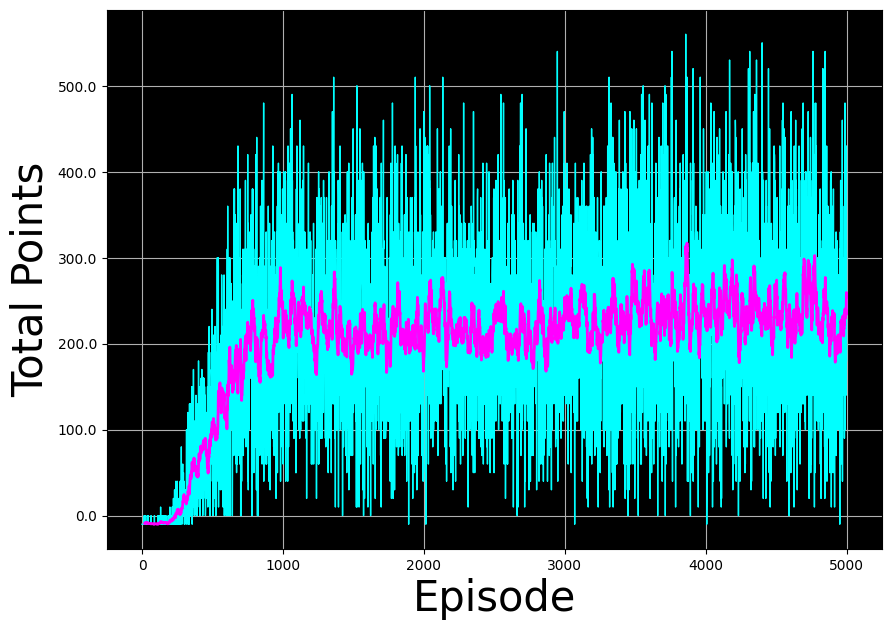

In [17]:
utils.plot_history(total_point_history)

In [18]:
q_network.save('./models/mysnake_model_3.h5')

In [21]:
filename = "./videos/snake_T3_1.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [58]:
filename = "./videos/snake_T3_2.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [72]:
filename = "./videos/snake_T3_3.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Four Training

In [14]:
start = time.time()

num_episodes = 4000
max_num_timesteps = 2000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()


    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 600.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('models/mysnake_model_4.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -9.10
Episode 200 | Total point average of the last 100 episodes: -8.20
Episode 300 | Total point average of the last 100 episodes: -0.90
Episode 400 | Total point average of the last 100 episodes: 36.40
Episode 500 | Total point average of the last 100 episodes: 83.00
Episode 600 | Total point average of the last 100 episodes: 127.80
Episode 700 | Total point average of the last 100 episodes: 165.40
Episode 800 | Total point average of the last 100 episodes: 183.50
Episode 900 | Total point average of the last 100 episodes: 207.20
Episode 1000 | Total point average of the last 100 episodes: 222.40
Episode 1100 | Total point average of the last 100 episodes: 227.20
Episode 1200 | Total point average of the last 100 episodes: 234.10
Episode 1300 | Total point average of the last 100 episodes: 218.00
Episode 1400 | Total point average of the last 100 episodes: 196.30
Episode 1500 | Total point average of the last 100 episodes: 2

In [15]:
q_network.save('./models/mysnake_model_4.h5')

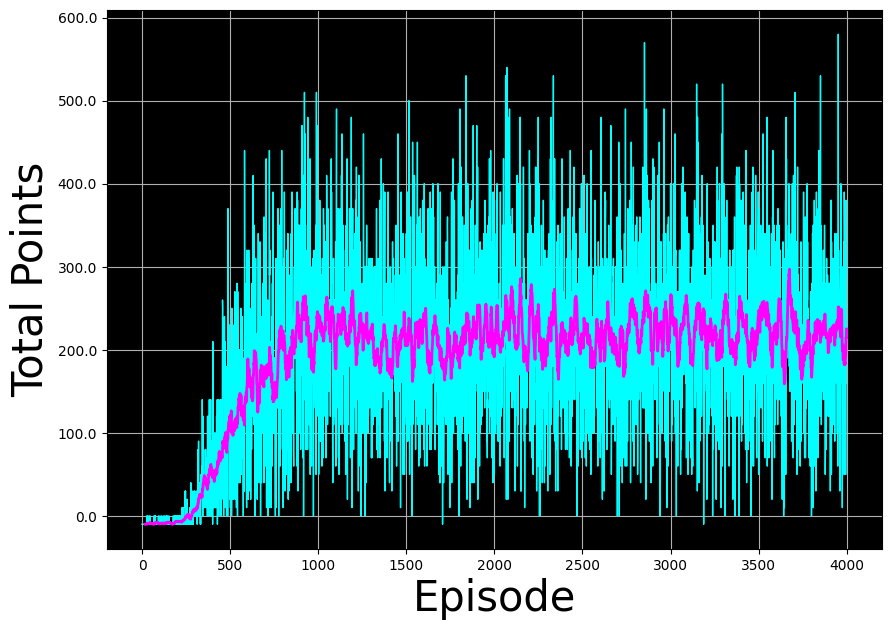

In [16]:
utils.plot_history(total_point_history)

In [21]:
filename = "./videos/snake_T4_1.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (132, 132) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Fifth Training

In [ ]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)    

In [ ]:
def train(num_episodes=2000, max_num_timesteps=1000, num_train = ""):

    start = time.time()

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
    epsilon = 1.0     # initial ε value for ε-greedy policy

    # Create a memory buffer D with capacity N
    memory_buffer = deque(maxlen=MEMORY_SIZE)

    # Set the target network weights equal to the Q-Network weights
    target_q_network.set_weights(q_network.get_weights())

    for i in range(num_episodes):
        
        # Reset the environment to the initial state and get the initial state
        state = env.reset()


        total_points = 0
        
        for t in range(max_num_timesteps):
            
            # From the current state S choose an action A using an ε-greedy policy
            state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
            q_values = q_network(state_qn)
            
            action = utils.get_action(q_values, epsilon)
            
            # Take action A and receive reward R and the next state S'
            next_state, reward, done, _ = env.step(action)
            
            # Store experience tuple (S,A,R,S') in the memory buffer.
            # We store the done variable as well for convenience.
            memory_buffer.append(experience(state, action, reward, next_state, done))
            
            # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
            update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
            
            if update:
                # Sample random mini-batch of experience tuples (S,A,R,S') from D
                experiences = utils.get_experiences(memory_buffer)
                
                # Set the y targets, perform a gradient descent step,
                # and update the network weights.
                agent_learn(experiences, GAMMA)
            
            state = next_state.copy()
            total_points += reward
            
            if done:
                break
                
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])
        
        # Update the ε value
        epsilon = utils.get_new_eps(epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 200 points in the last 100 episodes.
        if av_latest_points >= 400.0:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            # q_network.save(f'models/mysnake_model_{num_train}.h5')
            break
            
    tot_time = time.time() - start
    q_network.save(f'models/mysnake_model_{num_train}.h5')

    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)") 

    utils.plot_history(total_point_history) 

Episode 100 | Total point average of the last 100 episodes: -5.20
Episode 200 | Total point average of the last 100 episodes: 7.900
Episode 300 | Total point average of the last 100 episodes: 19.30
Episode 400 | Total point average of the last 100 episodes: 48.90
Episode 500 | Total point average of the last 100 episodes: 78.40
Episode 600 | Total point average of the last 100 episodes: 100.50
Episode 700 | Total point average of the last 100 episodes: 109.40
Episode 800 | Total point average of the last 100 episodes: 120.70
Episode 900 | Total point average of the last 100 episodes: 125.50
Episode 1000 | Total point average of the last 100 episodes: 130.40
Episode 1100 | Total point average of the last 100 episodes: 130.90
Episode 1200 | Total point average of the last 100 episodes: 142.30
Episode 1300 | Total point average of the last 100 episodes: 129.60
Episode 1400 | Total point average of the last 100 episodes: 137.20
Episode 1500 | Total point average of the last 100 episodes: 1

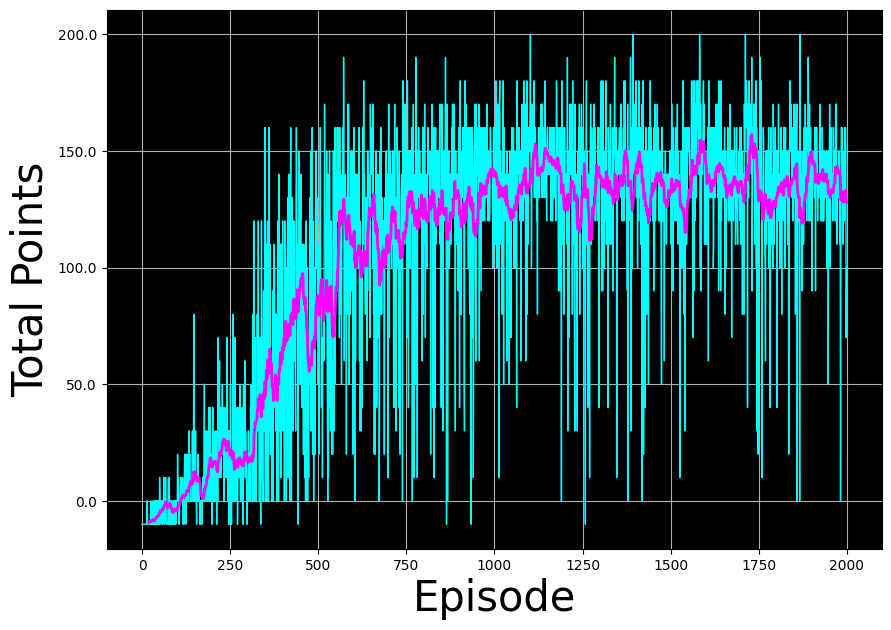

In [30]:
train(2000, 200, 5)

Episode 100 | Total point average of the last 100 episodes: -4.10
Episode 200 | Total point average of the last 100 episodes: 6.300
Episode 300 | Total point average of the last 100 episodes: 24.70
Episode 400 | Total point average of the last 100 episodes: 54.80
Episode 500 | Total point average of the last 100 episodes: 85.60
Episode 600 | Total point average of the last 100 episodes: 117.90
Episode 700 | Total point average of the last 100 episodes: 150.40
Episode 800 | Total point average of the last 100 episodes: 181.90
Episode 900 | Total point average of the last 100 episodes: 186.30
Episode 1000 | Total point average of the last 100 episodes: 202.80
Episode 1100 | Total point average of the last 100 episodes: 216.10
Episode 1200 | Total point average of the last 100 episodes: 205.70
Episode 1300 | Total point average of the last 100 episodes: 212.50
Episode 1400 | Total point average of the last 100 episodes: 213.70
Episode 1500 | Total point average of the last 100 episodes: 2

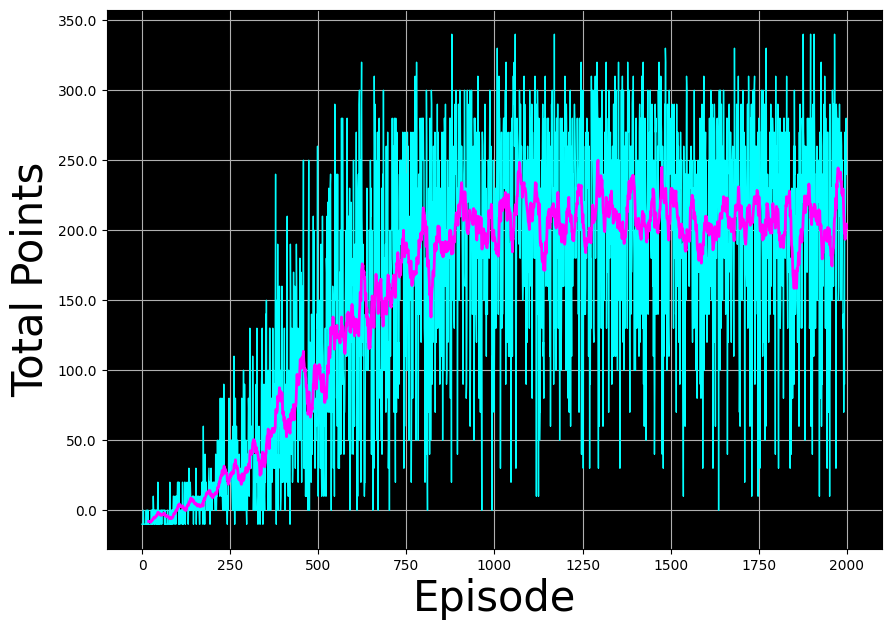

In [31]:
train(2000, 400, 5)